In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#Loading csv into dataframe
train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test.csv')

In [5]:
#Fetching labels
train_label = train['label']
test_label = test['label']

#Fetching pixel values
train_data =train.drop(columns=['label'])
test_data = test.drop(columns=['label'])

In [6]:
train_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [7]:
# Reshape train and test data
train_data=train_data.values.reshape(-1,28,28,1)
test_data=test_data.values.reshape(-1,28,28,1)

In [8]:
# normalize the data
train_data = train_data/255.
test_data = test_data/255.

In [9]:
print(train_data.shape, test_data.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


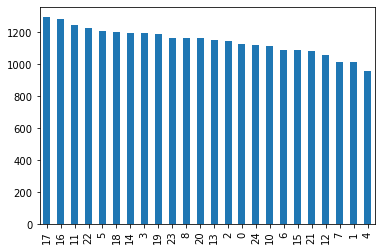

In [10]:
# Analysis to see if the data is properly distributed for all the categories
train.label.sort_values().value_counts().plot(kind = 'bar')



In [11]:
len(train['label'].sort_values().unique()) # there 24 unique labels available

24

In [12]:
print(len(train_label), len(train_data))

27455 27455


In [13]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
train_label = label_binarizer.fit_transform(train_label)
test_label = label_binarizer.fit_transform(test_label)

In [14]:
print(train_label.shape, test_label.shape)

(27455, 24) (7172, 24)


In [15]:
#divide data into train and validation
x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_label,test_size=0.2, shuffle= True)

In [16]:
print(x_train.shape, x_validation.shape, y_train.shape, y_validation.shape)

(21964, 28, 28, 1) (5491, 28, 28, 1) (21964, 24) (5491, 24)


In [17]:
# data augmentation
train_datagen = ImageDataGenerator(
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
validation_datagen = ImageDataGenerator()
train_datagen.fit(x_train)
validation_datagen.fit(x_validation)


training_gen = train_datagen.flow(x_train, y_train,batch_size=32)
validation_gen = validation_datagen.flow(x_validation, y_validation,batch_size=32)

In [18]:
#model

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(8, (3,3),strides=(1,1), activation='relu', input_shape=(28,28,1)),
                                    tf.keras.layers.Conv2D(8, (3,3),strides=(1,1), activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.ZeroPadding2D(padding=(1,1)),
                                    tf.keras.layers.Conv2D(16, (3,3),strides=(1,1), activation='relu'),
                                    tf.keras.layers.Conv2D(16, (3,3),strides=(1,1), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(16, (3,3),strides=(1,1), activation='relu'),
                                    tf.keras.layers.Conv2D(16, (3,3),strides=(1,1), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2,2)),                                    
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),                                    
                                    tf.keras.layers.Dense(24, activation='softmax')
                                   ])
#optimizer
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 8)         32        
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 16)        0

In [20]:

# Callbacks

Callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True), 
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

# Callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

# Train the Model
history = model.fit_generator(
    training_gen,
    epochs=50,
    steps_per_epoch= len(x_train)/32,    
    validation_data=validation_gen,
    validation_steps = len(x_validation)/32,
    callbacks = Callbacks
)

Epoch 1/50
687/686 [==============================] - 11s 16ms/step - loss: 2.7504 - accuracy: 0.1462 - val_loss: 2.1956 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 2/50
687/686 [==============================] - 11s 16ms/step - loss: 2.2471 - accuracy: 0.2777 - val_loss: 1.5348 - val_accuracy: 0.4782 - lr: 0.0010
Epoch 3/50
687/686 [==============================] - 11s 17ms/step - loss: 1.9690 - accuracy: 0.3571 - val_loss: 1.2673 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 4/50
687/686 [==============================] - 11s 16ms/step - loss: 1.7608 - accuracy: 0.4163 - val_loss: 1.1534 - val_accuracy: 0.6004 - lr: 0.0010
Epoch 5/50
687/686 [==============================] - 11s 16ms/step - loss: 1.6145 - accuracy: 0.4663 - val_loss: 1.7875 - val_accuracy: 0.3817 - lr: 0.0010
Epoch 6/50
687/686 [==============================] - 10s 15ms/step - loss: 1.4930 - accuracy: 0.5053 - val_loss: 0.8709 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 7/50
687/686 [==============================] - 10s 

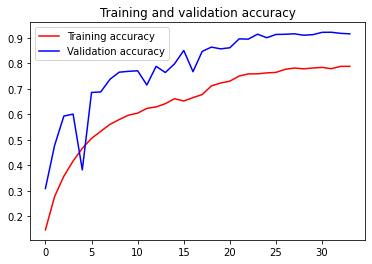

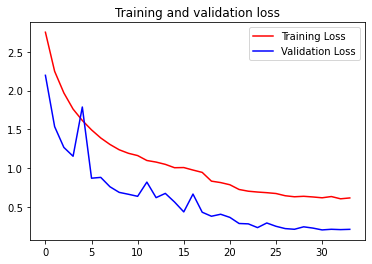

In [21]:
# Plot the chart for accuracy and loss on both training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
model.evaluate(test_data, test_label)

225/225 [==============================] - 1s 3ms/step - loss: 0.2871 - accuracy: 0.8892


[0.28710076212882996, 0.8891522884368896]